In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

def add_to_path(src_dir):
    if src_dir not in sys.path:
        sys.path.insert(0, src_dir)

add_to_path('code')

In [2]:
import json
import pickle
import random

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

from easydict import EasyDict as edict

from mac import MACNetwork
from utils import IntermediateLayerGetter, load_vocab
from datasets import GQADataset, collate_fn_gqa, ClevrDataset, collate_fn, collate_fn_gqa_objs
from visualize_attentions import plot_vqa_attn
from visualize_attentions import plot_word_img_attn_lobs, plot_word_img_attn_objs, idxs_to_question, question_to_idxs, get_image

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.empty(1, device=DEVICE)
print(DEVICE)

cuda


In [4]:
uni_model_dir = 'data/clevr_uni_gtlobs0/'

with open(os.path.join(uni_model_dir, 'cfg.json'), 'r') as f:
    uni_cfg = json.load(f)

In [5]:
orig_model_dir = 'data/clevr_orig_gtlobs0/'

with open(os.path.join(orig_model_dir, 'cfg.json'), 'r') as f:
    orig_cfg = json.load(f)

In [6]:
from config import __C, _merge_a_into_b

uni_cfg = edict(uni_cfg)
uni_cfg

{'GPU_ID': '0',
 'CUDA': True,
 'WORKERS': 1,
 'LOGDIR': 'clevr_uni_gtlobs0',
 'COMET_PROJECT_NAME': 'clevr-uniform',
 'EVAL': '',
 'TEST': False,
 'TEST_BATCH_SIZE': 128,
 'SAMPLE': False,
 'resume_model': None,
 'resume_model_ema': None,
 'start_epoch': None,
 'TRAIN': {'FLAG': True,
  'LEARNING_RATE': 0.0001,
  'BATCH_SIZE': 64,
  'MAX_EPOCHS': 50,
  'SNAPSHOT_INTERVAL': 5,
  'WEIGHT_INIT': 'xavier_uniform',
  'CLIP_GRADS': True,
  'CLIP': 8,
  'EALRY_STOPPING': True,
  'PATIENCE': 5,
  'VAR_DROPOUT': False,
  'RADAM': False},
 'DATASET': {'DATASET': 'clevr',
  'DATA_DIR': '/storage1/datasets/CLEVR_Uni_v1.0/data',
  'COGENT': '',
  'train_split': 'train',
  'params': {'feats_fname': '',
   'info_fname': '',
   'spatial_feats_dset_name': 'data',
   'objects_feats_dset_name': 'features',
   'objects_bboxes_dset_name': 'bboxes',
   'sample_size': 100}},
 'model': {'init_mem': 'random',
  'max_step': 4,
  'separate_syntax_semantics': False,
  'use_feats': 'spatial',
  'num_gt_lobs': 0,


In [7]:
from config import __C, _merge_a_into_b

orig_cfg = edict(orig_cfg)
orig_cfg

{'GPU_ID': '0',
 'CUDA': True,
 'WORKERS': 1,
 'LOGDIR': 'clevr_orig_gtlobs0',
 'COMET_PROJECT_NAME': 'clevr-orig',
 'EVAL': '',
 'TEST': False,
 'TEST_BATCH_SIZE': 128,
 'SAMPLE': False,
 'resume_model': None,
 'resume_model_ema': None,
 'start_epoch': None,
 'TRAIN': {'FLAG': True,
  'LEARNING_RATE': 0.0001,
  'BATCH_SIZE': 64,
  'MAX_EPOCHS': 50,
  'SNAPSHOT_INTERVAL': 5,
  'WEIGHT_INIT': 'xavier_uniform',
  'CLIP_GRADS': True,
  'CLIP': 8,
  'EALRY_STOPPING': True,
  'PATIENCE': 5,
  'VAR_DROPOUT': False,
  'RADAM': False},
 'DATASET': {'DATASET': 'clevr',
  'DATA_DIR': '/storage1/datasets/CLEVR_v1.0/features',
  'COGENT': '',
  'train_split': 'train',
  'params': {'feats_fname': '',
   'info_fname': '',
   'spatial_feats_dset_name': 'data',
   'objects_feats_dset_name': 'features',
   'objects_bboxes_dset_name': 'bboxes',
   'sample_size': 100}},
 'model': {'init_mem': 'random',
  'max_step': 4,
  'separate_syntax_semantics': False,
  'use_feats': 'spatial',
  'num_gt_lobs': 0,
  

In [8]:
dataset = 'clevr'
uniform = False

if dataset == 'clevr':
    # dataset_root = '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/'
    if uniform:
        dataset_root = '/storage1/datasets/CLEVR_Uni_v1.3/'
        data_dir = os.path.join(dataset_root, 'data')    
    else:
        dataset_root = '/storage1/datasets/CLEVR_v1.0/'
        data_dir = os.path.join(dataset_root, 'features')
    images_dir = os.path.join(dataset_root, 'images')
elif dataset == 'gqa':
    # dataset_root = '/Users/sebamenabar/Documents/datasets/GQA/'
    dataset_root = '/storage1/datasets/GQA/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
# cfg.DATASET.DATA_DIR = data_dir
# cfg.CUDA = False
# cfg.GPU_ID = '-1'

split = 'val'
if orig_cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=orig_cfg.DATASET.DATA_DIR,
        split=split,
        use_feats=use_feats,
        # **cfg.DATASET.params,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif orig_cfg.DATASET.DATASET == 'clevr':
    if uniform:
        spatial_feats_dset_name = 'data'
        questions_fname = f'CLEVR_uni_{split}_questions.json'
    else:
        spatial_feats_dset_name = 'data'
        questions_fname = f'CLEVR_{split}_questions.json'
    orig_ds = ClevrDataset(
        data_dir=data_dir,
        split=split,
        spatial_feats_dset_name=spatial_feats_dset_name,
    )
    with open(os.path.join(dataset_root, 'questions', questions_fname), 'r') as f:
        orig_ds.questions = json.load(f)['questions']

In [9]:
dataset = 'clevr'
uniform = True

if dataset == 'clevr':
    # dataset_root = '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/'
    if uniform:
        dataset_root = '/storage1/datasets/CLEVR_Uni_v1.3/'
        data_dir = os.path.join(dataset_root, 'data')    
    else:
        dataset_root = '/storage1/datasets/CLEVR_v1.0/'
        data_dir = os.path.join(dataset_root, 'features')
    images_dir = os.path.join(dataset_root, 'images')
elif dataset == 'gqa':
    # dataset_root = '/Users/sebamenabar/Documents/datasets/GQA/'
    dataset_root = '/storage1/datasets/GQA/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
# cfg.DATASET.DATA_DIR = data_dir
# cfg.CUDA = False
# cfg.GPU_ID = '-1'

split = 'val'
if uni_cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=uni_cfg.DATASET.DATA_DIR,
        split=split,
        use_feats=use_feats,
        **uni_cfg.DATASET.params,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif uni_cfg.DATASET.DATASET == 'clevr':
    if uniform:
        spatial_feats_dset_name = 'data'
        questions_fname = f'CLEVR_uni_{split}_questions.json'
    else:
        spatial_feats_dset_name = 'data'
        questions_fname = f'CLEVR_{split}_questions.json'
    uni_ds = ClevrDataset(
        data_dir=data_dir,
        split=split,
        spatial_feats_dset_name=spatial_feats_dset_name,
    )
    with open(os.path.join(dataset_root, 'questions', questions_fname), 'r') as f:
        uni_ds.questions = json.load(f)['questions']

In [10]:
vocab = load_vocab(uni_cfg)
reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']
num_answers = len(reverse_answer_dic)

In [11]:
uni_model = MACNetwork(uni_cfg, vocab, num_answers=num_answers).to(DEVICE)
state = torch.load(os.path.join(uni_model_dir, 'Model', 'model_checkpoint_000050.pth'))
print(uni_model.load_state_dict(state['model'], strict=False))
uni_model.eval()

<All keys matched successfully>


MACNetwork(
  (input_unit): InputUnit(
    (stem): Sequential(
      (0): Dropout(p=0.18, inplace=False)
      (1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.18, inplace=False)
      (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ELU(alpha=1.0)
    )
    (encoder): LSTM(300, 256, batch_first=True, bidirectional=True)
    (encoder_embed): Embedding(90, 300)
    (embedding_dropout): Dropout(p=0.15, inplace=False)
    (question_dropout): Dropout(p=0.08, inplace=False)
  )
  (output_unit): OutputUnit(
    (question_proj): Linear(in_features=512, out_features=512, bias=True)
    (classifier): Sequential(
      (0): Dropout(p=0.15, inplace=False)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.15, inplace=False)
      (4): Linear(in_features=512, out_features=28, bias=True)
    )
  )
  (mac): MACUnit(
    (control):

In [12]:
orig_model = MACNetwork(orig_cfg, vocab, num_answers=num_answers).to(DEVICE)
state = torch.load(os.path.join(orig_model_dir, 'Model', 'model_checkpoint_000050.pth'))
print(orig_model.load_state_dict(state['model'], strict=False))
orig_model.eval()

<All keys matched successfully>


MACNetwork(
  (input_unit): InputUnit(
    (stem): Sequential(
      (0): Dropout(p=0.18, inplace=False)
      (1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.18, inplace=False)
      (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ELU(alpha=1.0)
    )
    (encoder): LSTM(300, 256, batch_first=True, bidirectional=True)
    (encoder_embed): Embedding(90, 300)
    (embedding_dropout): Dropout(p=0.15, inplace=False)
    (question_dropout): Dropout(p=0.08, inplace=False)
  )
  (output_unit): OutputUnit(
    (question_proj): Linear(in_features=512, out_features=512, bias=True)
    (classifier): Sequential(
      (0): Dropout(p=0.15, inplace=False)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.15, inplace=False)
      (4): Linear(in_features=512, out_features=28, bias=True)
    )
  )
  (mac): MACUnit(
    (control):

In [13]:
uni_num_steps = uni_cfg.model.max_step
uni_num_lobs = uni_cfg.model.read_unit.num_lobs
uni_num_gt_lobs = uni_cfg.model.read_unit.num_gt_lobs
uni_read_gate = uni_cfg.model.read_unit.gate
uni_use_feats = uni_cfg.model.use_feats

return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
    # 'mac.read.gate_sigmoid': 'read_gate',
    # 'mac.read.lobs_attn_idty': 'lobs_attn',
}
if uni_read_gate:
    return_layers['mac.read.gate_sigmoid'] = 'read_gate'
if uni_num_lobs > 0:
    return_layers['mac.read.lobs_attn_idty'] = 'lobs_attn'  

uni_mid_getter = IntermediateLayerGetter(uni_model, return_layers, keep_output=True)

In [14]:
orig_num_steps = orig_cfg.model.max_step
orig_num_lobs = orig_cfg.model.read_unit.num_lobs
orig_num_gt_lobs = orig_cfg.model.read_unit.num_gt_lobs
orig_read_gate = orig_cfg.model.read_unit.gate
orig_use_feats = orig_cfg.model.use_feats

return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
    # 'mac.read.gate_sigmoid': 'read_gate',
    # 'mac.read.lobs_attn_idty': 'lobs_attn',
}
if orig_read_gate:
    return_layers['mac.read.gate_sigmoid'] = 'read_gate'
if orig_num_lobs > 0:
    return_layers['mac.read.lobs_attn_idty'] = 'lobs_attn'  

orig_mid_getter = IntermediateLayerGetter(orig_model, return_layers, keep_output=True)

In [15]:
print(uni_num_steps, orig_num_steps)
print(uni_num_gt_lobs, orig_num_gt_lobs)
print(uni_num_lobs, orig_num_lobs)
print(uni_read_gate, orig_read_gate)
print(uni_use_feats, orig_use_feats)

4 4
0 0
0 0
False False
spatial spatial


In [16]:
num_steps = 4
num_gt_lobs = 0
num_lobs = 0
read_gate = False
use_feats = 'spatial'

In [17]:
def show_and_tell(model, q_index, ds, images_dir, split='val'):
    if dataset == 'gqa':
        if use_feats == 'spatial':
            gqa_collate_fn = collate_fn_gqa
        elif use_feats == 'objects':
            gqa_collate_fn = collate_fn_gqa_objs
        b = gqa_collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    elif dataset == 'clevr':
        b = collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['image_filename']

    if type(b['image']) is tuple:
        b['image'] = tuple(v.to(DEVICE) for v in b['image'])
    else:
        b['image'] = b['image'].to(DEVICE)
    b['question'] = b['question'].to(DEVICE)

    with torch.no_grad():
        mid_outputs, output = model(b['image'], b['question'].to(DEVICE), b['question_length'],)

    kb_attn = torch.stack(mid_outputs['kb_attn']).squeeze(1).detach().cpu().numpy()
    plot_kwargs = dict(
        img_fp=os.path.join(images_dir, split, image_filename),
        num_steps=num_steps,

        words=idxs_to_question(b['question'][0].detach().cpu().numpy(), vocab['question_idx_to_token']),
        words_attn=torch.stack(mid_outputs['cw_attn']).squeeze().detach().cpu().numpy(),

        num_gt_lobs=num_gt_lobs,
        img_attn=kb_attn[:, :kb_attn.shape[1]-num_gt_lobs],
        gt_lobs_attn=kb_attn[:, kb_attn.shape[1]-num_gt_lobs:],

        prediction=vocab['answer_idx_to_token'][output.argmax().item()],
        real_answer= vocab['answer_idx_to_token'][b['answer'].item()],
    )

    fig = plot_vqa_attn(**plot_kwargs)
    
    
    
    if num_gt_lobs > 0:
        lobs_ax = fig.get_axes()[0]
        cw_ax = fig.get_axes()[2]
        img_ax = fig.get_axes()[4]
    else:
        cw_ax = fig.get_axes()[0]
        img_ax = fig.get_axes()[2]
    # print(ds.questions[q_index])
    cw_ax.set_title('Question %d' % q_index, fontsize=22)
    img_ax.set_title(image_filename, fontsize=22)
    print(image_filename)
    plt.tight_layout()
    plt.show()
    
    return fig

# Visualizaciones

In [255]:
q_index = 0

Entrenado en original

Entrenado en uniforme

## En set original

### Entrenado en uniforme evita más los bordes y atención sobre las palabras parece más clusterizada

CLEVR_val_000001.png


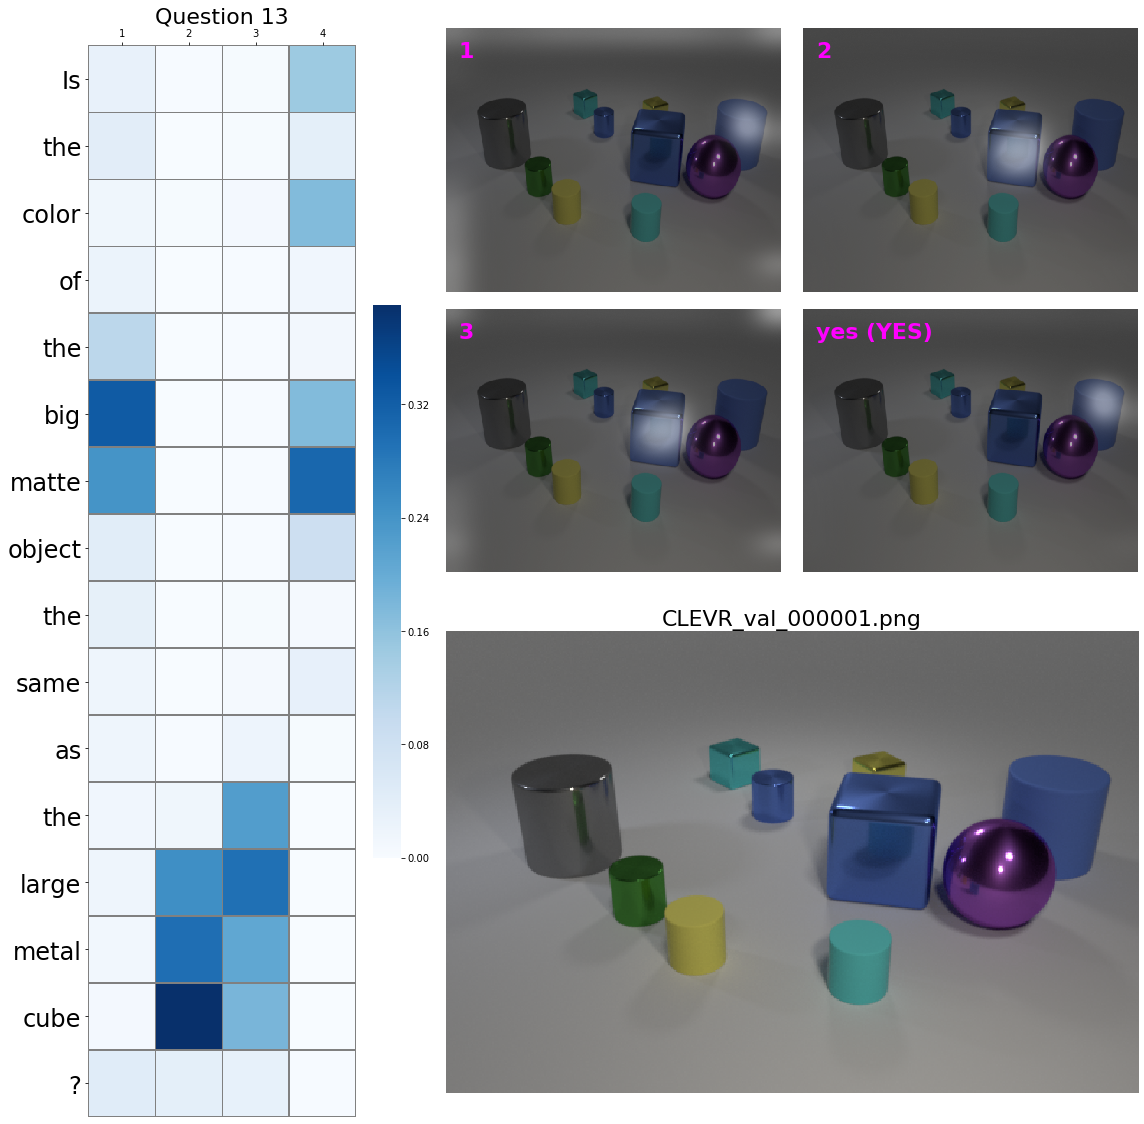

In [277]:
# q_index = 10
fig = show_and_tell(
    orig_mid_getter, q_index, orig_ds,
    images_dir='/storage1/datasets/CLEVR_v1.0/images'
)
# q_index += 13

CLEVR_val_000001.png


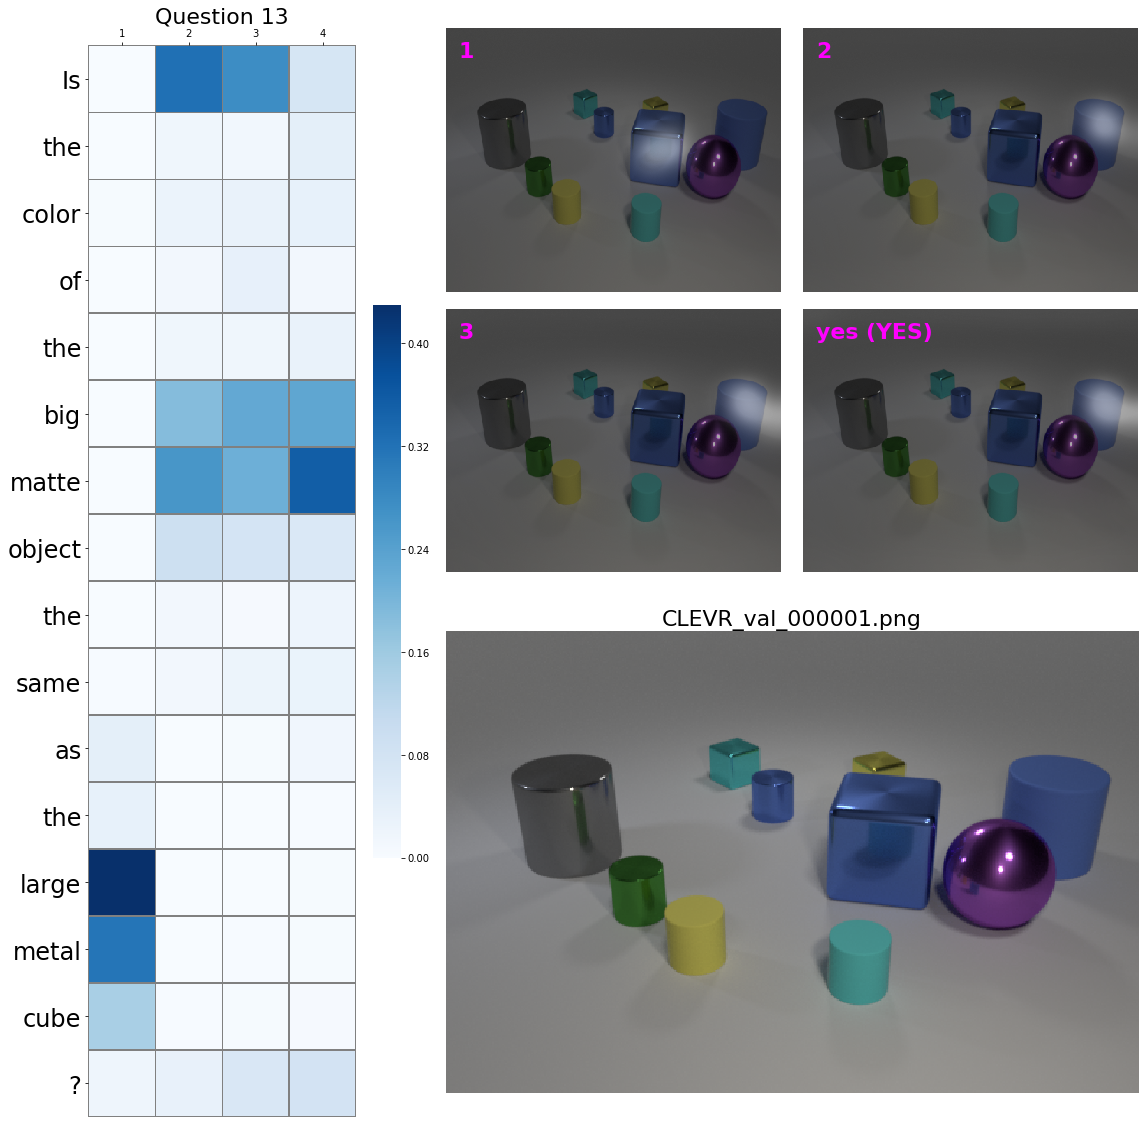

In [278]:
# q_index = 10
fig = show_and_tell(
    uni_mid_getter, q_index, orig_ds,
    images_dir='/storage1/datasets/CLEVR_v1.0/images'
)
q_index += 13

# Accuracy

In [258]:
from tqdm.autonotebook import tqdm

def calc_accuracy_and_get_answer(model, loader):
    total_correct = 0
    total_samples = 0
    pbar = tqdm(loader, total=len(loader))
    
    all_predictions = []
    all_answers = []
    
    for data in pbar:
        image, question, question_len, answer = data['image'], data['question'], data['question_length'], data['answer']
        answer = answer.long()
        image = image.to(DEVICE)
        question = question.to(DEVICE)
        answer = answer.to(DEVICE) # .squeeze()

        with torch.no_grad():
            scores = model(image, question, question_len)

        correct = scores.detach().argmax(1) == answer
        total_correct += correct.sum().cpu().item()
        total_samples += answer.size(0)

        avg_acc = total_correct / total_samples

        pbar.set_postfix({
            'Acc': f'{avg_acc:.5f}',
        })
        
        all_predictions.append(scores.detach().argmax(1).cpu().numpy())
        all_answers.append(answer.cpu().numpy())
        
    return all_predictions, all_answers

In [259]:
uni_loader = torch.utils.data.DataLoader(dataset=uni_ds, batch_size=256, drop_last=False,
                shuffle=False, num_workers=0, collate_fn=collate_fn)
orig_loader = torch.utils.data.DataLoader(dataset=orig_ds, batch_size=256, drop_last=False,
                shuffle=False, num_workers=0, collate_fn=collate_fn)

In [24]:
uni_on_orig_preds, uni_on_orig_ans = calc_accuracy_and_get_answer(uni_model, orig_loader)

KeyboardInterrupt: 

In [25]:
uni_on_uni_preds, uni_on_uni_ans = calc_accuracy_and_get_answer(uni_model, uni_loader)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [260]:
orig_on_uni_preds, orig_on_uni_ans = calc_accuracy_and_get_answer(orig_model, uni_loader)

KeyboardInterrupt: 

In [144]:
orig_on_orig_preds, orig_on_orig_ans = calc_accuracy_and_get_answer(orig_model, orig_loader)

In [19]:
import pickle

In [145]:
uni_on_orig_preds, uni_on_orig_ans = np.concatenate(uni_on_orig_preds), np.concatenate(uni_on_orig_ans)
with open('predictions/uni_on_orig.pkl', 'wb') as f:
    pickle.dump(
        {
            'preds': uni_on_orig_preds,
            'ans': uni_on_orig_ans,
        },
    f)

In [29]:
uni_on_uni_preds, uni_on_uni_ans = np.concatenate(uni_on_uni_preds), np.concatenate(uni_on_uni_ans)
with open('predictions/uni_on_uni.pkl', 'wb') as f:
    pickle.dump(
        {
            'preds': uni_on_uni_preds,
            'ans': uni_on_uni_ans,
        },
    f)

In [28]:
orig_on_uni_preds, orig_on_uni_ans = np.concatenate(orig_on_uni_preds), np.concatenate(orig_on_uni_ans)
with open('predictions/orig_on_uni.pkl', 'wb') as f:
    pickle.dump(
        {
            'preds': orig_on_uni_preds,
            'ans': orig_on_uni_ans,
        },
    f)

In [146]:
orig_on_orig_preds, orig_on_orig_ans = np.concatenate(orig_on_orig_preds), np.concatenate(orig_on_orig_ans)
with open('predictions/orig_on_orig.pkl', 'wb') as f:
    pickle.dump(
        {
            'preds': orig_on_orig_preds,
            'ans': orig_on_orig_ans,
        },
    f)

# Revisar

In [18]:
with open('predictions/uni_on_orig.pkl', 'rb') as f:
    algo = pickle.load(f)
    print(np.sum(algo['preds'] == algo['ans']) / len(algo['preds']))

0.946223440073071


In [19]:
with open('predictions/uni_on_uni.pkl', 'rb') as f:
    algo = pickle.load(f)
    print(np.sum(algo['preds'] == algo['ans']) / len(algo['preds']))

0.94706


In [20]:
with open('predictions/orig_on_uni.pkl', 'rb') as f:
    algo = pickle.load(f)
    print(np.sum(algo['preds'] == algo['ans']) / len(algo['preds']))

0.8106466666666666


In [21]:
with open('predictions/orig_on_orig.pkl', 'rb') as f:
    algo = pickle.load(f)
    print(np.sum(algo['preds'] == algo['ans']) / len(algo['preds']))

0.9787653925902221


# Comparar

In [22]:
from PIL import Image
from torchvision.models.resnet import ResNet, resnet101
import torchvision.transforms as transforms
from torchvision.transforms import Resize


def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    return x

resnet = resnet101(True).cuda()
resnet.eval()
resnet.forward = forward.__get__(resnet, ResNet)

transform = transforms.Compose([
    Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])

def preprocess(img_fp):
    img = Image.open(img_fp).convert('RGB')
    img = transform(img).unsqueeze(0)
    
    with torch.no_grad():
        out = resnet(img.cuda())
    
    return out

In [23]:
import pickle

In [24]:
with open('predictions/uni_on_uni.pkl', 'rb') as f:
    uni_on_uni_res = pickle.load(f)
with open('predictions/orig_on_uni.pkl', 'rb') as f:
    orig_on_uni_res = pickle.load(f)
    
uni_on_uni_preds, uni_on_uni_ans = uni_on_uni_res['preds'], uni_on_uni_res['ans']
orig_on_uni_preds, orig_on_uni_ans = orig_on_uni_res['preds'], orig_on_uni_res['ans']

In [25]:
uni_on_uni_correct = uni_on_uni_preds == orig_on_uni_ans
orig_on_uni_correct = orig_on_uni_preds == uni_on_uni_ans

uu_correct_idxs, = uni_on_uni_correct.nonzero()
ou_correct_idxs, = orig_on_uni_correct.nonzero()

print('Total correct Uni-on-Uni:', f'{len(uu_correct_idxs)}/{len(uni_on_uni_correct)} ({len(uu_correct_idxs)/len(uni_on_uni_correct)})')
print('Total correct Orig-on-Uni:', f'{len(ou_correct_idxs)}/{len(orig_on_uni_correct)} ({len(ou_correct_idxs)/len(orig_on_uni_correct)})')

print('Corrects intersection:', len(np.intersect1d(uu_correct_idxs, ou_correct_idxs)))

print('UoU correct and OoU wrong:', len(np.setdiff1d(uu_correct_idxs, ou_correct_idxs)))
print('OoU correct and UoU wrong:', len(np.setdiff1d(ou_correct_idxs, uu_correct_idxs)))

Total correct Uni-on-Uni: 142059/150000 (0.94706)
Total correct Orig-on-Uni: 121597/150000 (0.8106466666666666)
Corrects intersection: 117948
UoU correct and OoU wrong: 24111
OoU correct and UoU wrong: 3649


In [22]:
uuu_idxs = np.setdiff1d(uu_correct_idxs, ou_correct_idxs)
idx_iter = iter(uuu_idxs)
i = next(idx_iter)

In [118]:
i = next(idx_iter)
i

158

In [177]:
i = 115

CLEVR_uni_val3_000011.png


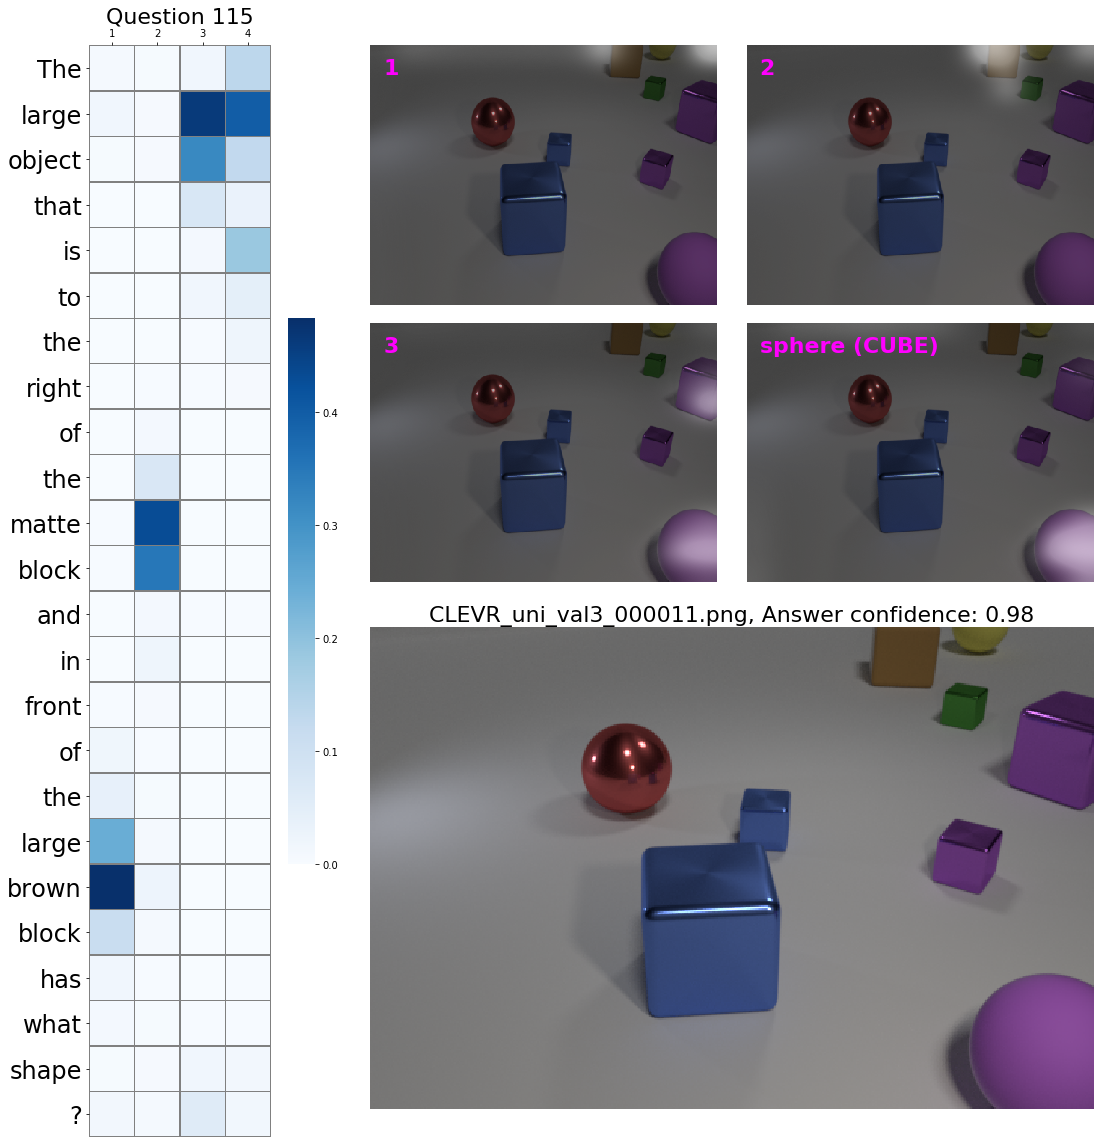

In [178]:
# q_index = 10
fig = show_and_tell(
    orig_mid_getter, i, uni_ds,
    images_dir='/storage1/datasets/CLEVR_Uni_v1.3/images'
)
# q_index += 13

CLEVR_uni_val3_000011.png


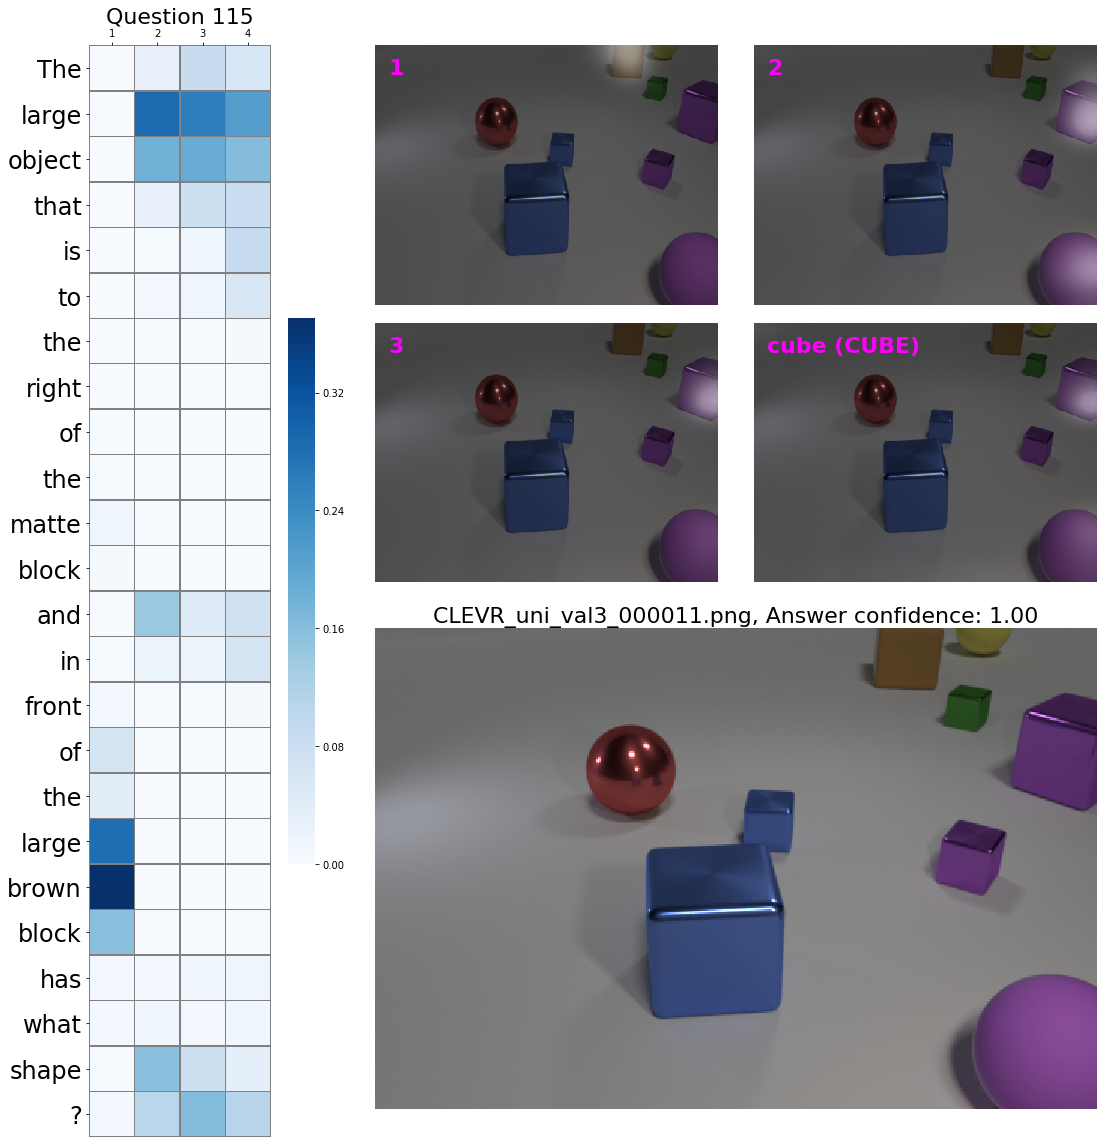

In [179]:
fig = show_and_tell(
    uni_mid_getter, i, uni_ds,
    images_dir='/storage1/datasets/CLEVR_Uni_v1.3/images'
)


#### Modelo original

#### Imagen arrreglada

CLEVR_uni_val3_000011.png


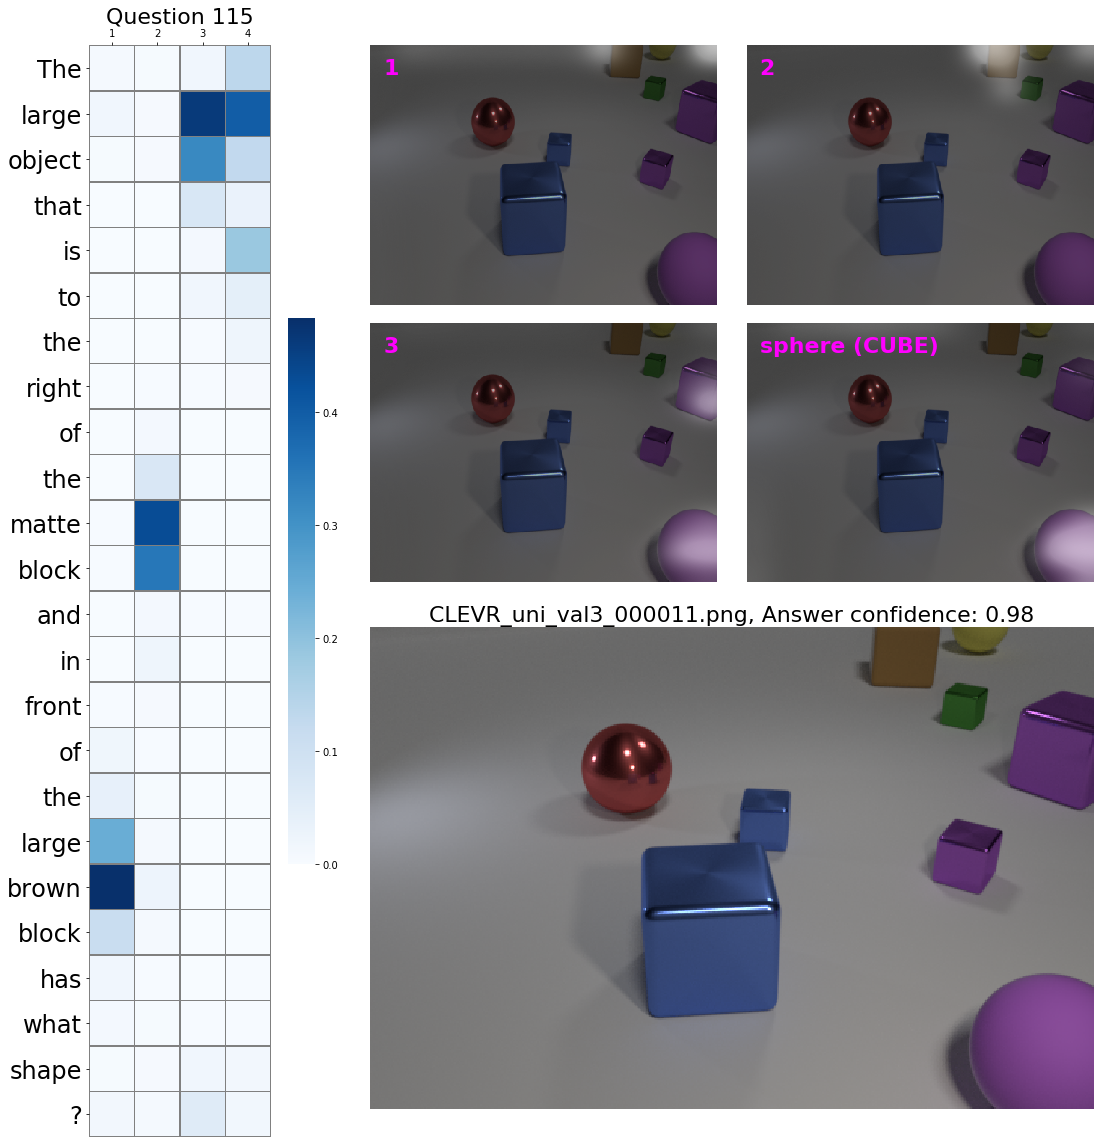

In [133]:
fig = show_and_tell(
    orig_mid_getter, i, uni_ds,
    images_dir='/storage1/datasets/CLEVR_Uni_v1.3/images'
)

CLEVR_uni_val3_000006.png


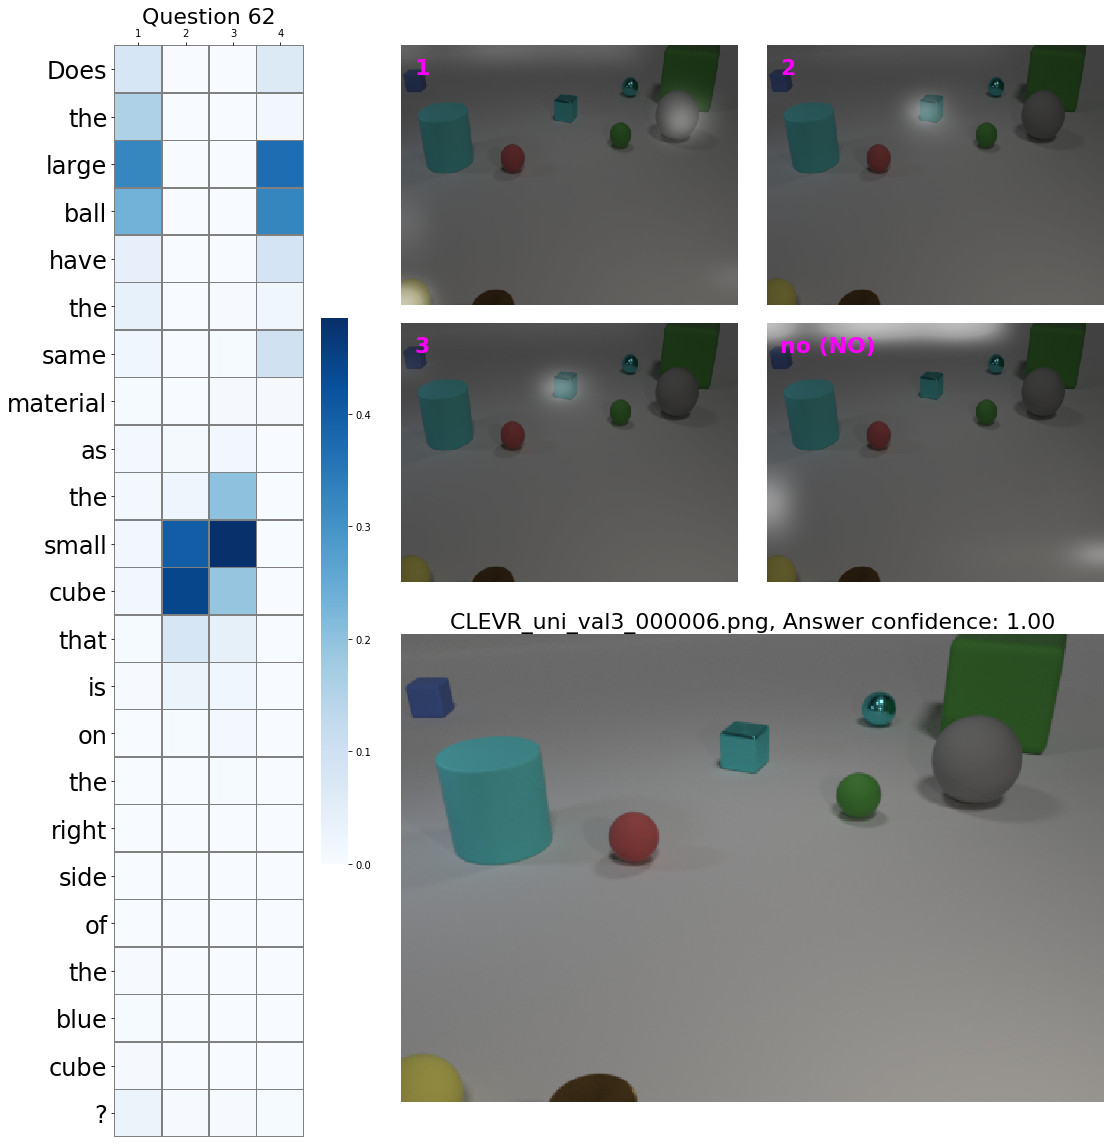

In [150]:
fig = show_and_tell(
    orig_mid_getter,
    i, uni_ds, None,
    img_fp='/storage1/samenabar/code/CLMAC/clevr-dataset-gen/pruebas.png',
)

#### Preguntas manuales

In [180]:
# img_fp = '/storage1/samenabar/code/CLMAC/clevr-dataset-gen/pruebas.png'
img_fp = os.path.join('/storage1/datasets/CLEVR_Uni_v1.3/images', 'val', 'CLEVR_uni_val3_000011.png')

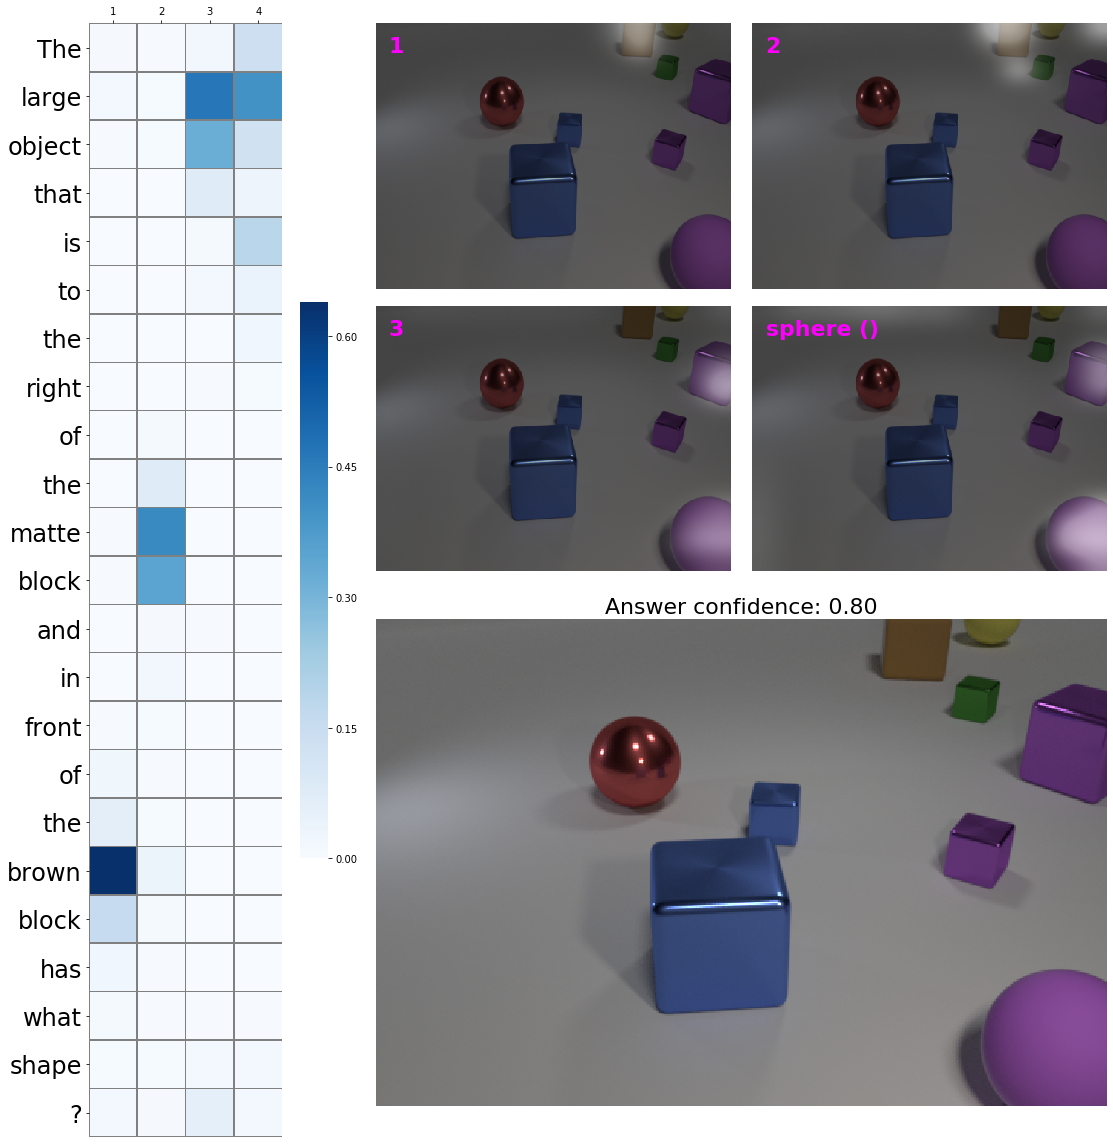

In [183]:
fig = manual_question(
    model=orig_mid_getter,
    question='The large object that is to the right of the matte block and in front of the brown block has what shape ?',
    img_fp=img_fp,
)

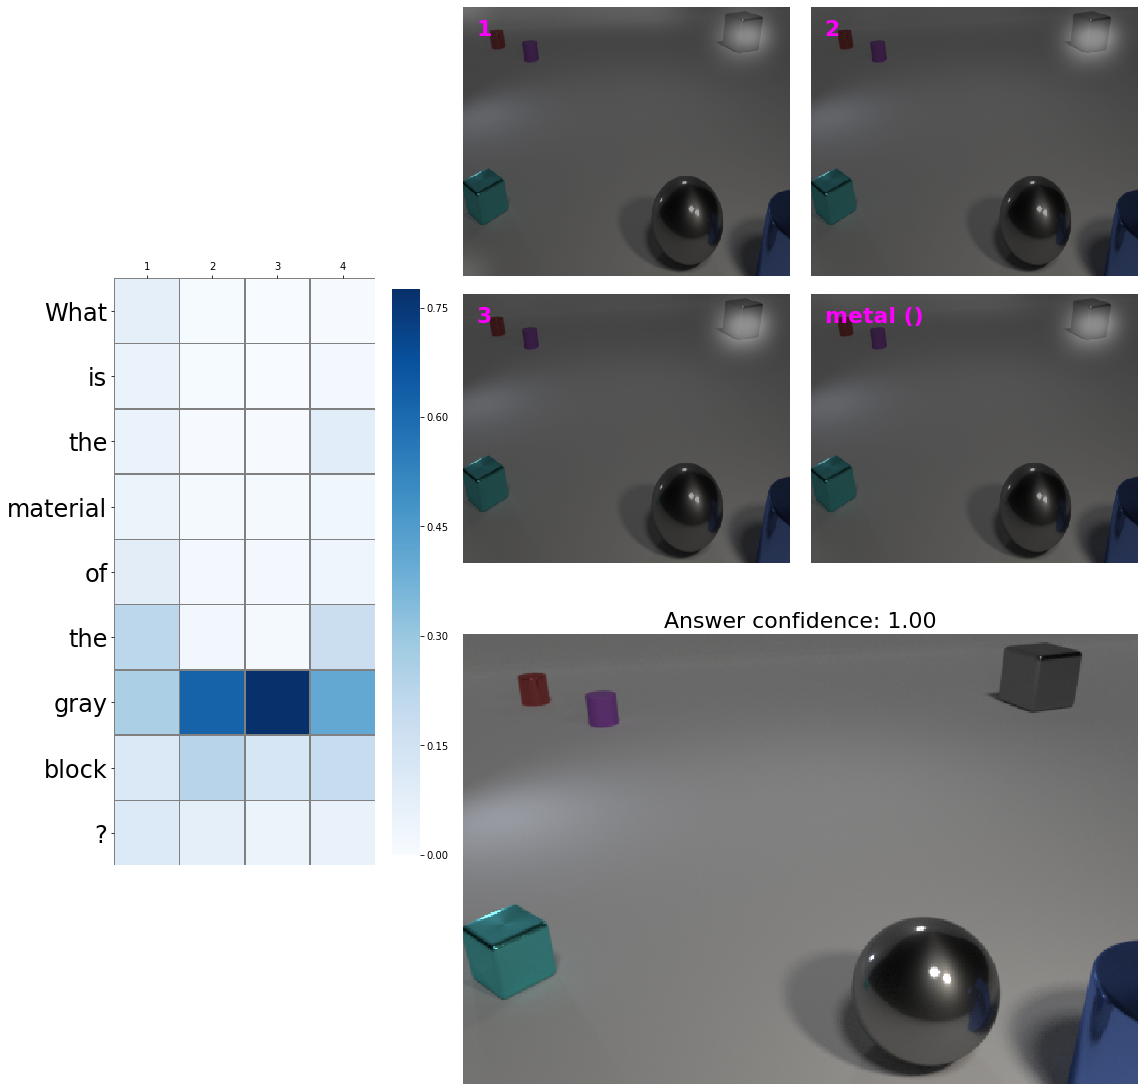

In [105]:
fig = manual_question(
    model=orig_mid_getter,
    question='What is the material of the gray block ?',
    img_fp=img_fp,
)

In [107]:
i = next(idx_iter)
#i = random.choice(uuu_idxs)
print(i)

154


In [50]:
def manual_question(model, question, img_fp):
    model.eval()
    
    image = preprocess(img_fp).to(DEVICE)
    question_len = [len(question.split())]
    tensor_question = torch.as_tensor(question_to_idxs(question, vocab['question_token_to_idx'])).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        mid_outputs, output = model(image, tensor_question, question_len)
        
    prediction = vocab['answer_idx_to_token'][output.argmax().item()],
    # print(output.softmax(dim=1).max(dim=1).values.item())
    
    kb_attn = torch.stack(mid_outputs['kb_attn']).squeeze(1).detach().cpu().numpy()
    plot_kwargs = dict(
        img_fp=img_fp,
        num_steps=num_steps,

        words=question.split(),
        words_attn=torch.stack(mid_outputs['cw_attn']).squeeze().detach().cpu().numpy(),

        num_gt_lobs=num_gt_lobs,
        img_attn=kb_attn[:, :kb_attn.shape[1]-num_gt_lobs],
        gt_lobs_attn=kb_attn[:, kb_attn.shape[1]-num_gt_lobs:],

        prediction=vocab['answer_idx_to_token'][output.argmax().item()],
        # real_answer= vocab['answer_idx_to_token'][b['answer'].item()],
    )

    fig = plot_vqa_attn(**plot_kwargs)
    
    cw_ax = fig.get_axes()[0]
    # cw_ax.set_title('Question %d' % q_index, fontsize=22)
    img_ax = fig.get_axes()[2]
    # print(ds.questions[q_index])
    img_ax.set_title(f'Answer confidence: {output.softmax(dim=1).max(dim=1).values.item():.2f}', fontsize=22)
    plt.tight_layout()
    plt.show()
    
    return fig

In [108]:
torch.as_tensor(question_to_idxs('What is the shape of the green object', vocab['question_token_to_idx']))

tensor([30, 32, 18, 20, 17, 18,  5, 25])

In [48]:
def show_and_tell(model, q_index, ds, images_dir, split='val', img_fp=None):
    model.eval()
    if dataset == 'gqa':
        if use_feats == 'spatial':
            gqa_collate_fn = collate_fn_gqa
        elif use_feats == 'objects':
            gqa_collate_fn = collate_fn_gqa_objs
        b = gqa_collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    elif dataset == 'clevr':
        b = collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['image_filename']

    if type(b['image']) is tuple:
        b['image'] = tuple(v.to(DEVICE) for v in b['image'])
    else:
        b['image'] = b['image'].to(DEVICE)
    b['question'] = b['question'].to(DEVICE)
    
    if img_fp:
        image = preprocess(img_fp)
    else:
        image = b['image']
        img_fp = os.path.join(images_dir, split, image_filename)

    with torch.no_grad():
        mid_outputs, output = model(image, b['question'].to(DEVICE), b['question_length'],)

    # print('pred', output.argmax(1))
    # print('ans', b['answer'])
    kb_attn = torch.stack(mid_outputs['kb_attn']).squeeze(1).detach().cpu().numpy()
    plot_kwargs = dict(
        img_fp=img_fp,
        num_steps=num_steps,

        words=idxs_to_question(b['question'][0].detach().cpu().numpy(), vocab['question_idx_to_token']),
        words_attn=torch.stack(mid_outputs['cw_attn']).squeeze().detach().cpu().numpy(),

        num_gt_lobs=num_gt_lobs,
        img_attn=kb_attn[:, :kb_attn.shape[1]-num_gt_lobs],
        gt_lobs_attn=kb_attn[:, kb_attn.shape[1]-num_gt_lobs:],

        prediction=vocab['answer_idx_to_token'][output.argmax().item()],
        real_answer= vocab['answer_idx_to_token'][b['answer'].item()],
    )

    fig = plot_vqa_attn(**plot_kwargs)
    
    cw_ax = fig.get_axes()[0]
    cw_ax.set_title('Question %d' % q_index, fontsize=22)
    img_ax = fig.get_axes()[2]
    # print(ds.questions[q_index])
    print(image_filename)
    img_ax.set_title(f'{image_filename}, Answer confidence: {output.softmax(dim=1).max(dim=1).values.item():.2f}', fontsize=22)
    plt.tight_layout()
    plt.show()
    
    return fig

## Según posición

In [26]:
from PIL import Image
import json
from tqdm import tqdm_notebook as tqdm

In [27]:
uni_ds_root = '/storage1/datasets/CLEVR_Uni_v1.3/'
with open(os.path.join(uni_ds_root, 'scenes', 'CLEVR_uni_val3_scenes.json'), 'r') as f:
    uni_scenes = json.load(f)['scenes']

In [28]:
# Objects needed to reason about for ansnwering question i correctly
all_qobjects = []

for i, q in tqdm(enumerate(uni_ds), total=len(uni_ds)):
    qinfo = uni_ds.questions[i]
    qscene = uni_scenes[qinfo['image_index']]
    qobjects = set()

    for op in qinfo['program'][1:-1]:
        if type(op['_output']) is list:
            for obj_idx in op['_output']:
                obj = qscene['objects'][obj_idx]
                obj['3d_coords'] = tuple(obj['3d_coords'])
                obj['pixel_coords'] = tuple(obj['pixel_coords'])

                qobjects.add((obj_idx, tuple(sorted(obj.items()))))
                
    all_qobjects.append(qobjects)

In [29]:
# Objects that appear in the scene of a question
all_objs_in_question_scene = []

for i, q in tqdm(enumerate(uni_ds), total=len(uni_ds)):
    qinfo = uni_ds.questions[i]
    qscene = uni_scenes[qinfo['image_index']]
    all_objs_in_question_scene.append(qscene['objects'])

In [32]:
# Wethere the question requires to reason about an object located in the top 50 pixels of the image
requires = []
for qobjects in all_qobjects:
    added = False
    for obj in qobjects:
        # print(obj[1][3][1])
        if obj[1][3][1][1] < 50:
            requires.append(True)
            added = True
            break
    if not added:
        requires.append(False)
        # break
    # break
    
requires = np.array(requires)
len(requires)

150000

In [30]:
# Wether the question has an object in the last 50 pixels of the image
question_scene_has = []

for objects in all_objs_in_question_scene:
    _has = False
    for obj in objects:
        if obj['pixel_coords'][1] < 50:
            question_scene_has.append(True)
            _has = True
            break
    if not _has:
        question_scene_has.append(False)
question_scene_has = np.array(question_scene_has)

In [33]:
question_scene_has_but_doesnt_require = question_scene_has & (~requires)

In [47]:
print('Accuracy of orig-model on questions that have an object in the top 50 pixels but don\'t require to reason about it:')
print((orig_on_uni_correct[question_scene_has_but_doesnt_require].sum(), question_scene_has_but_doesnt_require.sum(), orig_on_uni_correct[question_scene_has_but_doesnt_require].sum() / question_scene_has_but_doesnt_require.sum(),), '\n')

print('Accuracy of orig-model on questions that have to reason about an object on the top 50 pixels')
print((orig_on_uni_correct[requires].sum(), requires.sum(), orig_on_uni_correct[requires].sum() / requires.sum(), ), '\n')

print('Accuracy of orig-model on questions that don\'t have objects in the top 50 pixels')
print((orig_on_uni_correct[(~question_scene_has)].sum(), (~question_scene_has).sum(), orig_on_uni_correct[(~question_scene_has)].sum() / (~question_scene_has).sum(), ), '\n')

Accuracy of orig-model on questions that have an object in the top 50 pixels but don't require to reason about it:
(12496, 14346, 0.8710441935034156) 

Accuracy of orig-model on questions that have to reason about an object on the top 50 pixels
(83301, 108154, 0.7702072970024225) 

Accuracy of orig-model on questions that don't have objects in the top 50 pixels
(25800, 27500, 0.9381818181818182) 



In [49]:
print('Accuracy of uni-model on questions that have an object in the top 50 pixels but don\'t require to reason about it:')
print((uni_on_uni_correct[question_scene_has_but_doesnt_require].sum(), question_scene_has_but_doesnt_require.sum(), uni_on_uni_correct[question_scene_has_but_doesnt_require].sum() / question_scene_has_but_doesnt_require.sum(),), '\n')

print('Accuracy of uni-model on questions that have to reason about an object on the top 50 pixels')
print((uni_on_uni_correct[requires].sum(), requires.sum(), uni_on_uni_correct[requires].sum() / requires.sum(),), '\n') 
       
print('Accuracy of uni-model on questions that don\'t have objects in the top 50 pixels')
print((uni_on_uni_correct[(~question_scene_has)].sum(), (~question_scene_has).sum(), uni_on_uni_correct[(~question_scene_has)].sum() / (~question_scene_has).sum(), ), '\n')

Accuracy of uni-model on questions that have an object in the top 50 pixels but don't require to reason about it:
(14131, 14346, 0.9850132441098564) 

Accuracy of uni-model on questions that have to reason about an object on the top 50 pixels
(101389, 108154, 0.9374503023466538) 

Accuracy of uni-model on questions that don't have objects in the top 50 pixels
(26539, 27500, 0.9650545454545455) 



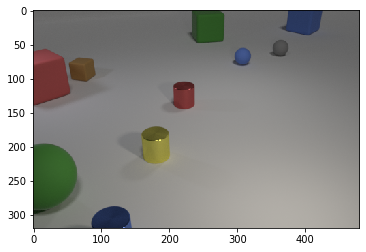

In [154]:
scene = uni_scenes[0]
img_fp = os.path.join(uni_ds_root, 'images/val', scene['image_filename'])
img = Image.open(img_fp)

plt.imshow(img)

In [51]:
width, height = 480, 320
w_step, h_step = 20, 20

usage_table_orig = np.zeros((width // w_step, height // h_step, 2))
print(usage_table_orig.shape)

for question, qobjects, correct in tqdm(zip(uni_ds.questions, all_qobjects, orig_on_uni_correct), total=len(uni_ds)):
    
    already_counted = np.zeros((width // w_step, height // h_step))
    
    for obj in qobjects:
        pixel_coords = obj[1][3][1]
        w_pos, h_pos = pixel_coords[:2]
        w_pos = np.clip(w_pos, 0, width - 1)
        h_pos = np.clip(h_pos, 0, height - 1)
        
        w_box, h_box = w_pos // w_step, h_pos // h_step
        
        # print(obj, w_pos, h_pos, w_box, h_box)
        
        if not already_counted[w_box, h_box]:
            already_counted[w_box, h_box] = 1
            usage_table_orig[w_box, h_box, 0] += correct
            usage_table_orig[w_box, h_box, 1] += 1
            

(24, 16, 2)


In [52]:
width, height = 480, 320
w_step, h_step = 20, 20

usage_table_uni = np.zeros((width // w_step, height // h_step, 2))
print(usage_table_uni.shape)

for question, qobjects, correct in tqdm(zip(uni_ds.questions, all_qobjects, uni_on_uni_correct), total=len(uni_ds)):
    
    already_counted = np.zeros((width // w_step, height // h_step))
    
    for obj in qobjects:
        pixel_coords = obj[1][3][1]
        w_pos, h_pos = pixel_coords[:2]
        w_pos = np.clip(w_pos, 0, width - 1)
        h_pos = np.clip(h_pos, 0, height - 1)
        
        w_box, h_box = w_pos // w_step, h_pos // h_step
        
        # print(obj, w_pos, h_pos, w_box, h_box)
        
        if not already_counted[w_box, h_box]:
            already_counted[w_box, h_box] = 1
            usage_table_uni[w_box, h_box, 0] += correct
            usage_table_uni[w_box, h_box, 1] += 1
            

(24, 16, 2)


Text(0.5, 1.0, 'Original model')

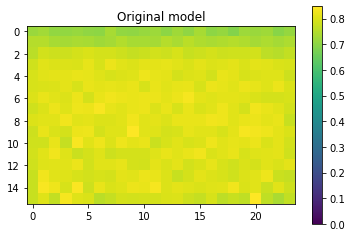

In [53]:
plt.imshow((usage_table_orig[:,:,0] / usage_table_orig[:,:,1]).transpose(), vmin=0 )
plt.colorbar()
plt.title('Original model')

Text(0.5, 1.0, 'Uniform model')

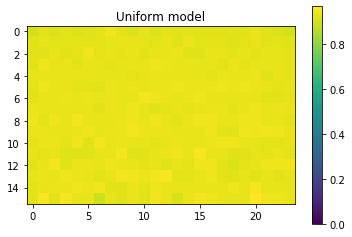

In [56]:
plt.imshow((usage_table_uni[:,:,0] / usage_table_uni[:,:,1]).transpose(), vmin=0 )
plt.colorbar()
plt.title('Uniform model')

In [81]:
len(all_qobjects)

150000

In [57]:
import pandas as pd

In [196]:
orig_on_uni_correct.sum() / len(orig_on_uni_correct), len(orig_on_uni_correct)

(0.8106466666666666, 150000)

In [197]:
orig_on_uni_correct[has.nonzero()].sum() / len(orig_on_uni_correct[has.nonzero()]), len(orig_on_uni_correct[has.nonzero()])

(0.7702072970024225, 108154)

In [198]:
orig_on_uni_correct[(~has).nonzero()].sum() / len(orig_on_uni_correct[(~has).nonzero()]), len(orig_on_uni_correct[(~has).nonzero()])

(0.9151651292835635, 41846)

In [182]:
all_objects = []
for scene in tqdm(uni_scenes):
    all_objects += scene['objects']

In [41]:
all_pixel_coords = np.array([o['pixel_coords'][:2] for o in all_objects])

In [47]:
import matplotlib.pyplot as plt

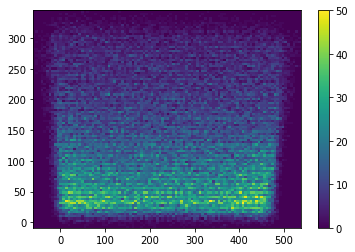

In [46]:
plt.hist2d(all_pixel_coords[:, 0], all_pixel_coords[:, 1], bins=100)
plt.colorbar()